## Eli EEG gel data

Example notebook to test the data that Eli sent me on 2024-09-27 regarding his EEG gel collaboration with the group in Edmonton.

## Import libraries

In [1]:
# Common packages
import numpy as np
import matplotlib.pyplot as plt
import pyxdf
import mne
import sys
import seaborn as sns

## Local packages
sys.path.append('..')
from Functions import import_data
from Functions.eeg_quality_index import EEGQualityIndex

## Magic commands
# - Interactive plots
%matplotlib qt

# - Autoreload packages
%load_ext autoreload
%autoreload 3

## Eyes open

Import data file and visualize EEG data.

eyes_open_tension
Creating RawArray with float64 data, n_channels=16, n_times=31488
    Range : 0 ... 31487 =      0.000 ...   122.996 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
['FP1', 'F3', 'T7', 'C5', 'C3', 'P3', 'PO3', 'O1', 'FP2', 'F4', 'T8', 'C6', 'C4', 'P4', 'PO4', 'O2']
['Fp1', 'F3', 'T7', 'C5', 'C3', 'P3', 'PO3', 'O1', 'Fp2', 'F4', 'T8', 'C6', 'C4', 'P4', 'PO4', 'O2']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 8449 samples (33.004 sec)



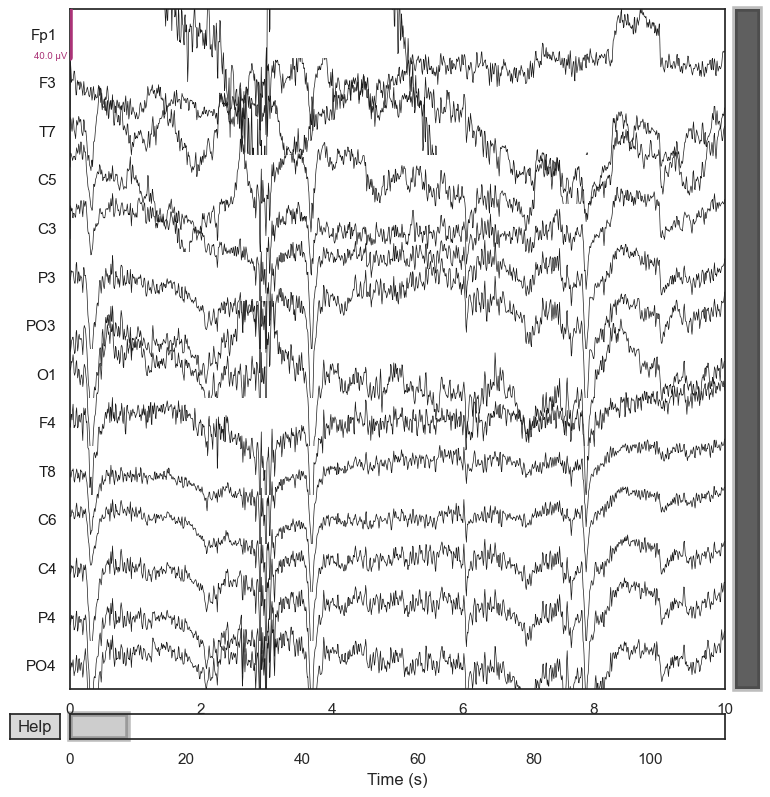

In [15]:
import re

eeg_file = r'..\\Data\\Data_Edmonton_Gels_Sept2024\\sub-P001\\ses-S001\\eeg\\sub-P001_ses-S001_task-eyes_open_tension_run-001_eeg.xdf'

# Extract the words following :ses-S001_ up until _run
match = re.search(r'sub-P001_ses-S001_task-(.*?)_run-001_eeg.xdf', eeg_file)
if match:
    extracted_words = match.group(1)
    print(extracted_words)
    data_case = extracted_words

mne_data = import_data.xdf_to_mne(eeg_file)

#Rereference to FP2
mne_data.set_eeg_reference(ref_channels=['FP2'])
print(mne_data.info.ch_names)
#Rename the FP1 and FP2 channels to Fp1 and Fp2
mne_data.rename_channels({'FP1': 'Fp1', 'FP2': 'Fp2'})
print(mne_data.info.ch_names)

#Add the 10-20 montage
montage = mne.channels.make_standard_montage('standard_1020')
mne_data.set_montage(montage)

#Drop the first 10 seconds and last 10 seconds of data
mne_data.crop(tmin=10, tmax=mne_data.times[-10])

#Remove FP2 and O2 channels
mne_data.drop_channels(['Fp2','O2'])

#Make a copy of the data for cleaning, another for raw
mne_data_raw = mne_data.copy()
mne_data_clean = mne_data.copy()
#Clean the data with simple bandpass filtering
mne_data_clean.filter(.1, 40)

mne_data_clean.plot()

Make clean epoch for referencing, based ICA, then visual inspection

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 14 components


c:\Users\Eli\mambaforge\envs\eeg_quality\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
c:\Users\Eli\mambaforge\envs\eeg_quality\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Fitting ICA took 5.9s.
Creating RawArray with float64 data, n_channels=14, n_times=28919
    Range : 2560 ... 31478 =     10.000 ...   122.961 secs
Ready.


c:\Users\Eli\mambaforge\envs\eeg_quality\lib\site-packages\sklearn\decomposition\_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
c:\Users\Eli\mambaforge\envs\eeg_quality\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
c:\Users\Eli\mambaforge\envs\eeg_quality\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
c:\Users\Eli\mambaforge\envs\eeg_quality\lib\site-packages\mne\utils\check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
c:\Users\Eli\mambaforge\envs\eeg_quality\lib\si

Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components


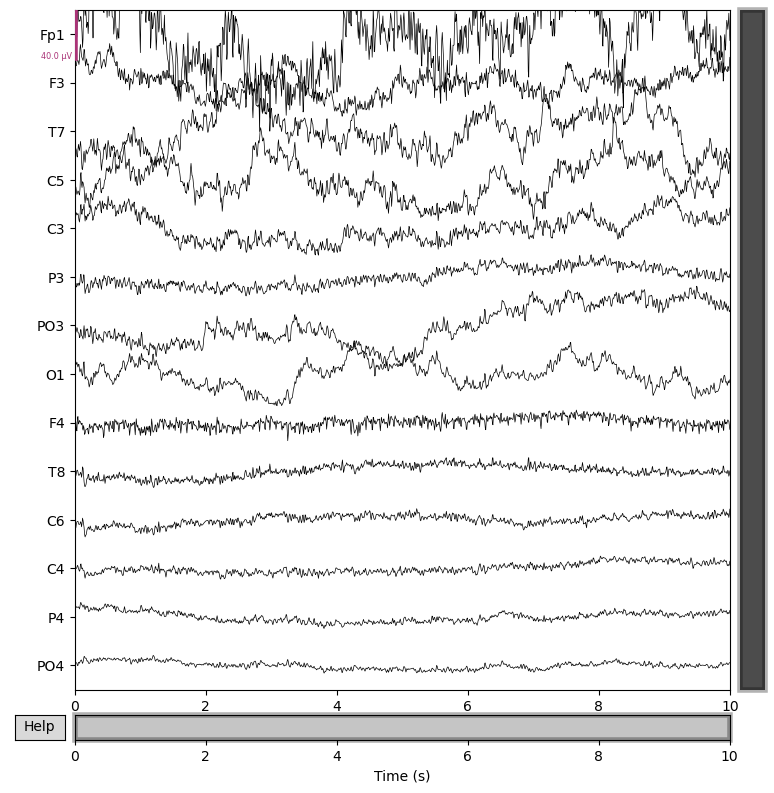

In [3]:
#Make the clean epoch

ica = mne.preprocessing.ICA(n_components=None, random_state=42, max_iter='auto')
ica.fit(mne_data_clean)
ica.plot_sources(mne_data_clean)
ica.plot_components()

#Pretty clear there is eye blink happening in ICA 0 and ICA 1
ica.exclude = [0, 1]

#If we want to see how this affects our original raw data
reconst_raw = mne_data.copy()
ica.apply(reconst_raw)
# mne_data.plot()
# reconst_raw.plot()

#If we want to see how this affects our original clean data
# mne_ica_clean = reconst_raw.filter(.1, 40)
# mne_ica_clean.plot()
#make a copy of the ica_cleaned data
mne_ica_clean = mne_data_clean.copy()
ica.apply(mne_ica_clean)
mne_ica_clean.plot()

#This is only available in the 1.8 or older version of MNE
# explained_var_ratio = ica.get_explained_variance_ratio(filt_raw)
# for channel_type, ratio in explained_var_ratio.items():
#     print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

#This clean epoch is only for eyes_open_tension_run-001
clean_epoch = mne_ica_clean.crop(tmin=37, tmax=47)
clean_epoch.plot()

Extract EEG data and compute EEG quality index

In [4]:
srate = mne_data.info['sfreq']
sliding = True
slide_window = int(1 * srate)   # Sliding window size [sec * samples = samples]
slide_step = int(0.5 * srate)   # Sliding window step [sec * samples = samples]            
clean_eeg = clean_epoch.get_data()
test_eeg = mne_data_raw.get_data()
# Initialize the EEG Quality Index object
eeg_quality_index = EEGQualityIndex(clean_eeg,test_eeg, srate, sliding=sliding, window = slide_window, slide = slide_step)

#Filtered data
test_filt_eeg = mne_data_clean.get_data()
# Compute the EEG Quality Index
filt_eeg_quality_index = EEGQualityIndex(clean_eeg,test_filt_eeg, srate, sliding=sliding, window = slide_window, slide = slide_step)



In [5]:
#Run the EQI
eqi_score = eeg_quality_index.compute_zscores()
[eqi_total, eqi_percent, eqi_mean] = eeg_quality_index.compute_zscores()

[filt_total, filt_percent, filtt_eqi_mean] = filt_eeg_quality_index.compute_zscores()

Visualize EEG quality index

In [6]:
#Visualize things
import pandas as pd
sns.set_theme(style="white")
baseline_channels = mne_data_clean.ch_names

row_names = ['$SSAS_{1-50 Hz}$', '$SASS_{60 Hz}$', 'RMS', '$Grad_{max}$', 'ZCR', 'Kurtosis']
column_names = baseline_channels + ['Mean']

# Generate a large random dataset
raw_percent_df = pd.DataFrame(data=np.concatenate((eqi_percent, np.mean(eqi_percent,1,keepdims=True)), axis=1), 
                            columns=column_names, index=row_names)

filt_percent_df = pd.DataFrame(data=np.concatenate((filt_percent, np.mean(filt_percent,1,keepdims=True)), axis=1), 
                            columns=column_names, index=row_names)

# Set up the matplotlib figure
f, ax = plt.subplots(2,1)

# Generate a custom diverging colormap
cmap1 = sns.diverging_palette(230, 20, as_cmap=True)
cmap2 = sns.diverging_palette(150, 275, as_cmap=True)

# Draw the heatmap
sns.heatmap(raw_percent_df, cmap=cmap1, vmax=100, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[0])
ax[0].set_title('EEG Quality Index\nBaseline (raw) vs Clean (eyes open)')

sns.heatmap(filt_percent_df, cmap=cmap2, vmax=100, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[1])
ax[1].set_title('Baseline (filtered) vs Clean (eyes open)')

plt.tight_layout()

In [9]:
import os

# Create the directory if it doesn't exist
analysis_dir = r'..\\Data\\Data_Edmonton_Gels_Sept2024\\Analysis\\'
if not os.path.exists(analysis_dir):
    os.makedirs(analysis_dir)

In [10]:
import os

# Create the directory if it doesn't exist
analysis_dir = r'..\\Data\\Data_Edmonton_Gels_Sept2024\\Analysis\\'
if not os.path.exists(analysis_dir):
    os.makedirs(analysis_dir)

#Handle Info for eyes Open vs eyes closed vs no tension for both   

    # Save the figures
f.savefig(analysis_dir + data_case + 'eeg_quality_index.png')

# Save the dataframes to CSV files
raw_percent_df.to_csv(analysis_dir + data_case + 'raw_percent_df.csv')
filt_percent_df.to_csv(analysis_dir + data_case + 'filt_percent_df.csv')
